In [54]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

from postamats.utils import prepare_data, helpers
from postamats.utils.connections import DB
from postamats.global_constants import APARTMENT_HOUSES_NAME, ALL_METRO_NAME, ALL_OBJECTS_NAME
from postamats.utils.connections import PATH_TO_ROOT

pd.set_option('display.max_columns', None)

In [2]:
CONFIG_PATH = os.path.join(PATH_TO_ROOT, 'db_config.json')
with open(CONFIG_PATH, mode='r') as db_file:
    db_config = json.load(db_file)
database = DB(db_config)

Загружаем базы

In [92]:
all_apart = database.get_table_from_bd(APARTMENT_HOUSES_NAME)
all_metro = database.get_table_from_bd(ALL_METRO_NAME)
all_objs = database.get_table_from_bd(ALL_OBJECTS_NAME)

Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Connection to PostgreSQL DB successful
Connection to PostgreSQL DB successful


/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)
/Users/affernus/PROJECTS/hacks/postomat_optimisation/src/postamats/utils/connections.py:96: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Эмулируем входящий json

In [112]:
json_input = {
    'possible_points': all_objs.sample(n=7000, random_state=0)['object_id'].to_list(),
    'fixed_points': all_objs.sample(n=500, random_state=0)['object_id'].to_list(),
    'metro_weight': 0.5
}
print(type(json_input))
with open('json_input.json', 'w') as fp:
    json.dump(json_input, fp, indent=4)

<class 'dict'>


In [114]:
with open('json_input.json', mode='r') as f:
    json_input = json.load(f)

possible_points = json_input['possible_points']
fixed_points = json_input['fixed_points']
metro_weight = json_input['metro_weight']

In [122]:
posiible_obj = all_objs[all_objs['object_id'].isin(possible_points)]
fixed_obj =  all_objs[all_objs['object_id'].isin(fixed_points)]

In [ ]:
posiible_obj_cartesian = helpers.calc_cartesian_coords(posiible_obj['lat'], posiible_obj['lon'])
fixed_obj_cartesian = helpers.calc_cartesian_coords(fixed_obj['lat'], fixed_obj['lon'])

In [123]:
def filter_all_in_neighborhood(x_fixed, y_fixed, x_all, y_all, min_dist=250):
    x_dist = abs(x_all - x_fixed)
    y_dist = abs(y_all - y_fixed)
    dist = x_dist**2 + y_dist**2
    return dist > min_dist

In [5]:
all_apart.head()

,category,on_moscow_territory,address,simple_address,street,local_object_type,local_object_num,korpus_num,stroenie_num,adm_area,district,num_addr_register,date_addr_register,guid_fias,date_fias,kad_n,kad_zu,kladr_code,addr_status,geodata,lat,lon,object_id,address_gis,address_code_gis,guid_fias_gis,oktmo_code_gis,management_method_gis,management_ogrn_gis,management_kpp_gis,management_name_gis,house_type_gis,condition_gis,total_area_gis,living_area_gis,demolition_date_gis,kad_n_gis,guid_house_gis,object_id_gis,object_type,population
0,Здание,да,"город Москва, Авиационная улица, дом 65, корпу...","Авиационная улица, дом 65, корпус 3, строение 4",Авиационная улица,дом,65,3,4,Северо-Западный административный округ,муниципальный округ Щукино,8008022,21.09.2006,9E6647F0-DC35-4A33-83DA-24405F5D439C,23.05.2013,77:08:0000000:2781,77:08:0009004:6867,77000000000071200,Внесён в ГКН,"{{37.4539473334854,55.8078787837879},{37.45407...",55.807827,37.453977,c7ad8391b30a404697edcfdea4ba10fa7ea552b4e09269...,"123182, Москва г, ул. Авиационная, д. 65, корп. 3",a00cecf4-a88d-4156-98a1-9157dec5bde1,A00CECF4-A88D-4156-98A1-9157DEC5BDE1,45372000,УО,5137746235611,773401001,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МО...,Многоквартирный,Исправный,46.8,3597.4,None,77:08:0000000:2781,40f56ef2-aa05-41a5-aade-9da3f090b996,4dfa8a03e8ee627671fbf571901abf381776a9839fd715...,многоквартирный дом,1.640880
1,Здание,да,"Российская Федерация, город Москва, внутригоро...","улица Мусы Джалиля, дом 16, корпус 2, строение 2",улица Мусы Джалиля,дом,16,2,2,Южный административный округ,муниципальный округ Зябликово,5006518,18.11.2003,86BC76E7-A676-4B69-A66D-839A3F37A733,24.11.2011,77:05:0012001:1093,77:05:0012001:1011,77000000000048000,Внесён в ГКН,"{{37.7392150814377,55.6235062851872},{37.73921...",55.623560,37.739392,7b9adf96d39c350de4fdf992f1ff2e497b1f8f5838cd9f...,"115573, Москва г, ул. Мусы Джалиля, д. 16, кор...",275e370b-1719-4150-8727-d85060951270,275E370B-1719-4150-8727-D85060951270,45916000,УО,1157746524231,772401001,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МО...,Многоквартирный,Исправный,261.0,7225.0,None,77:05:0012001:1093,4fb6a145-0e38-4933-8659-55aa9ddc9522,4eefe3d848079234315dbddcdcc9aa458b3f8f42adfc4f...,многоквартирный дом,18.310403
2,Здание,да,"Российская Федерация, город Москва, внутригоро...","Костромская улица, дом 8А",Костромская улица,дом,8А,None,None,Северо-Восточный административный округ,муниципальный округ Алтуфьевский,2205537,24.11.2004,A4BE6AFA-EE43-47FB-B895-A1B210DC1808,27.02.2012,77:02:0003005:1047,77:02:0003005:43,77000000000155300,Внесён в ГКН,"{{37.5930191098546,55.8857993631666},{37.59301...",55.885641,37.593456,eea53cceda9ab91905922e4fad25b4b146cfb647488f23...,"127549, Москва г, ул. Костромская, д. 6",be80f3a1-810b-414e-802c-236fa1a1a43e,BE80F3A1-810B-414E-802C-236FA1A1A43E,45350000,УО,5147746339362,771501001,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МО...,Многоквартирный,Исправный,2208.2,10131.3,None,77:02:0003005:1047,8852ff6f-b8d3-4433-8f86-72e6254b1a71,5747c5ed39bc899900b70fac83508f543df84aba0c4990...,многоквартирный дом,146.843127
3,Здание,да,"Российская Федерация, город Москва, внутригоро...","Варшавское шоссе, дом 120, корпус 2",Варшавское шоссе,дом,120,2,None,Южный административный округ,муниципальный округ Чертаново Северное,5015945,22.09.2015,1CC881F1-79D8-47A9-9442-DB7941505175,04.05.2017,77:05:0006004:24499,77:05:0006004:1003,77000000000047600,Внесён в ГКН,"{{37.6173230078642,55.6305115581333},{37.61731...",55.630294,37.617104,9d0f9c193a2b3c86da7b807d19c8884113b0d2421b7155...,"117587, Москва г, ш. Варшавское, д. 120, корп. 2",1b059a8b-53bd-4197-ad33-794d61c3898c,5C284593-7C29-49C9-8EE0-4DEA030D98F9,45924000,УО,1027700082266,773401001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ПИК-...",Многоквартирный,Исправный,13324.9,9005.6,None,77:05:0006004:24499,ed9ceea8-cb2a-4b59-85c1-1647497ed8d3,874706a86f21585085ab35c6a5e6331fc200835f72f1b7...,многоквартирный дом,657.938209
4,Здание,да,"город Москва, Кусковская улица, дом 29,

In [10]:
all_metro.head()

,object_id_metro,adm_area,district,object_type,lat,lon,address,population
0,cb102f6b9d341d9fdc1a4571088a7d91d29862167c76e8...,-,-,станция метро,55.755193,37.632493,китай-город (калужско-рижская линия),52078
1,1c99788b270f0a957fed01e194ea9f9abab54a536109b2...,-,-,станция метро,55.656790,37.540167,калужская (калужско-рижская линия),31556
2,9355e0e2f696e3562ac04a1df34b786912ce2d00f75ba4...,-,-,станция метро,55.659516,37.750832,братиславская (люблинско-дмитровская линия),34299
3,36d333776dfcb9d4b139584ba6183b2df25d0d7e6fde99...,-,-,станция метро,55.545011,37.541645,бульвар адмирала ушакова (бутовская линия легк...,8754
4,4647f51e2a77a555354ed313104a885d4911a4bb4b4689...,-,-,станция метро,55.569328,37.576555,бульвар дмитрия донского (серпуховско-тимирязе...,48209


In [30]:
all_objs.head()

,object_id,adm_area,district,object_type,lat,lon,address
0,c7ad8391b30a404697edcfdea4ba10fa7ea552b4e09269...,Северо-Западный административный округ,муниципальный округ Щукино,многоквартирный дом,55.807827,37.453977,"город Москва, Авиационная улица, дом 65, корпу..."
1,7b9adf96d39c350de4fdf992f1ff2e497b1f8f5838cd9f...,Южный административный округ,муниципальный округ Зябликово,многоквартирный дом,55.623560,37.739392,"Российская Федерация, город Москва, внутригоро..."
2,eea53cceda9ab91905922e4fad25b4b146cfb647488f23...,Северо-Восточный административный округ,муниципальный округ Алтуфьевский,многоквартирный дом,55.885641,37.593456,"Российская Федерация, город Москва, внутригоро..."
3,9d0f9c193a2b3c86da7b807d19c8884113b0d2421b7155...,Южный административный округ,муниципальный округ Чертаново Северное,многоквартирный дом,55.630294,37.617104,"Российская Федерация, город Москва, внутригоро..."
4,e6c1cae0d69e48fc18621c51ffd1fd2b54dbf13c6d38b5...,Восточный административный округ,муниципальный округ Новогиреево,многоквартирный дом,55.742228,37.784629,"город Москва, Кусковская улица, дом 29, корпус..."


In [15]:
n_clusters = 10**4
clusterer = KMeans(n_clusters=n_clusters)
labels = clusterer.fit_predict(apart_cartesian)

In [71]:
centers = clusterer.cluster_centers_.T
centers_cartesian = pd.DataFrame()
centers_cartesian['x'] = centers[0]
centers_cartesian['y'] = centers[1]

In [31]:
apart_cartesian = helpers.calc_cartesian_coords(all_apart['lat'], all_apart['lon'])
all_objs_cartesian = helpers.calc_cartesian_coords(all_objs['lat'], all_objs['lon'])

In [78]:
all_objs = all_objs.join(all_objs_cartesian)

In [80]:
filter_obj_type = 'киоск'
all_objs_filtered = all_objs[all_objs['object_type']==filter_obj_type]

In [83]:
distances = pairwise_distances(centers_cartesian, all_objs_cartesian.loc[all_objs_filtered.index, :])

In [84]:
best_points_ind = distances.argmin(axis=1)

In [85]:
best_points = all_objs.iloc[best_points_ind, :]

In [86]:
best_points

,object_id,adm_area,district,object_type,lat,lon,address,x,y
40737,2468c155a0c977105a860f815968bc490ef1507ffd38ef...,Северо-Восточный административный округ,Бабушкинский район,киоск,55.870642,37.665485,"город Москва, Енисейская улица, дом 24",2986.620899,12747.791129
41529,0403d85032e7cac12e9b67474a58a5d8bf4b7e4b6e08ad...,Юго-Западный административный округ,район Зюзино,киоск,55.648496,37.578205,"город Москва, Керченская улица, дом 13, строен...",-2468.262774,-11924.896981
39417,c7c64ff42221a59c36a8a5e42590489797608dde82ae04...,Восточный административный округ,район Перово,киоск,55.739818,37.772166,"город Москва, улица Лазо, дом 7",9654.039989,-1782.152420
40921,a051a899ab8ec8dfeb7f8b9d498b442a03fec3f93d9855...,Северо-Западный административный округ,район Хорошёво-Мнёвники,киоск,55.777743,37.477525,"город Москва, улица Народного Ополчения, дом 2...",-8760.652036,2429.990149
40550,a771c364b6628b87d4e19264519c77bf0ae82330385e55...,Новомосковский административный округ,поселение Марушкинское,киоск,55.596025,37.208690,"город Москва, поселение Марушкинское, деревня ...",-25562.412123,-17752.552705
...,...,...,...,...,...,...,...,...,...
38324,48facb1d6fee6e33d963dd7517a0cd52e38e90f37a9133...,Восточный административный округ,район Северное Измайлово,киоск,55.803894,37.759521,"Российская Федерация, город Москва, внутригоро...",8863.771066,5334.474112
38339,07fca44092ef5d22fafc875953de37ce5c7f669a6026fc...,Восточный административный округ,район Вешняки,киоск,55.722473,37.812927,"город Москва, Снайперская улица, дом 6, корпус 1",12201.556487,-3708.554778
41384,bd203cbb1a0717bc5dd8598b27fc2d8b8a56f75f13aa8a...,Юго-Восточный административный округ,район Люблино,киоск,55.667336,37.774417,"город Москва, улица Верхние Поля, дом 45, корп...",9794.724369,-9832.381245
38925,d8eee0c228b7231fca89e5df75dbb80799e0d58eafd321...,Северо-Западный административный округ,район Щукино,киоск,55.795829,37.489348,"Российская Федерация, город Москва, внутригоро...",-8021.697642,4438.743095


In [87]:
best_points_cartesian = all_objs_cartesian.loc[best_points_ind, :]

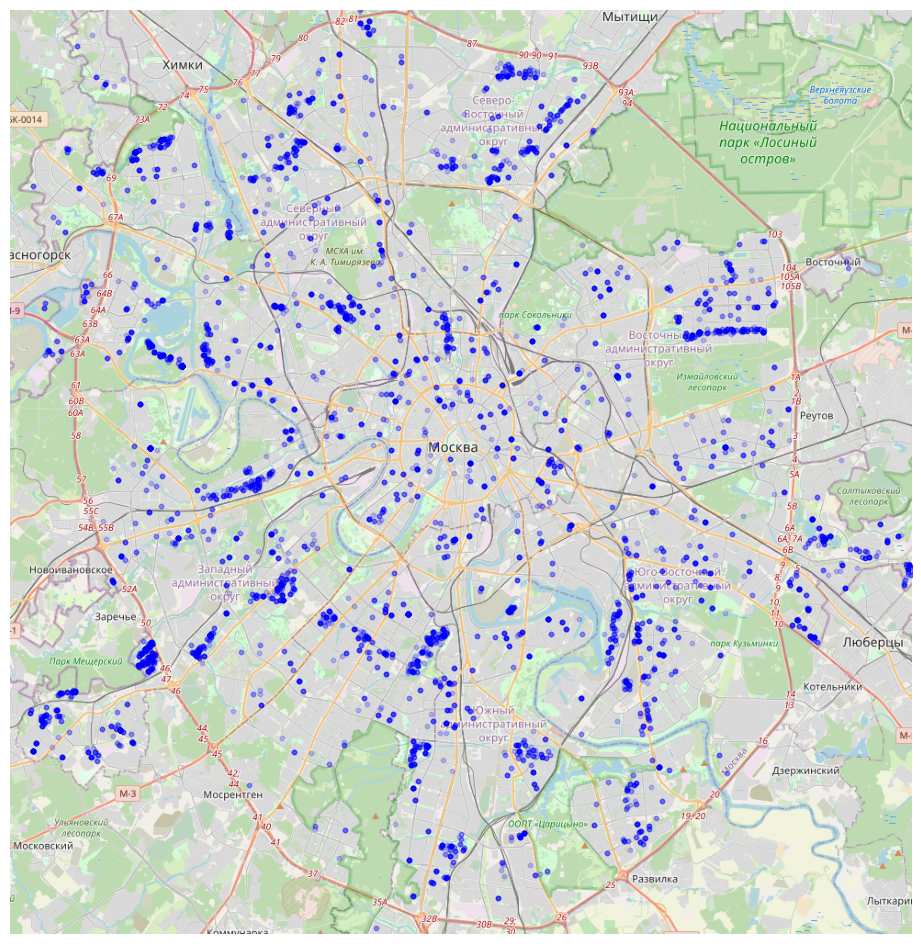

In [89]:
mos_img = plt.imread(os.path.join(PATH_TO_ROOT, 'data', 'images', 'map.png'))

bbox_geo = (37.3260, 37.9193, 55.5698, 55.9119)
bbox_cartes = helpers.calc_cartesian_coords(bbox_geo[2:], bbox_geo[:2])
bbox = bbox_cartes['x'].to_list() + bbox_cartes['y'].to_list()

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(best_points_cartesian['x'], best_points_cartesian['y'], zorder=1, alpha=0.2, c='b', s=10)
# ax.scatter(centers[0], centers[1], zorder=1, alpha=1, c='r', s=1)

ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.axis('off')
ax.imshow(mos_img, zorder=0, extent=bbox, aspect='equal')
plt.show()